# Analyse de données et Clustering - Korea Income and Welfare

Ce notebook propose une analyse approfondie du jeu de données "Korea Income and Welfare", avec pour objectif d'identifier des groupes homogènes via des méthodes de clustering. L'accent est mis sur le choix des méthodes, la préparation des données, l'interprétation des résultats et la discussion des limites.

In [1]:
# 1. Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

## 2. Chargement et aperçu des données

In [3]:
# Chargement du CSV
df = pd.read_csv('Korea Income and Welfare.csv')
df.head()

,id,year,wave,region,income,family_member,gender,year_born,education_level,marriage,religion,occupation,company_size,reason_none_worker
0,10101,2005,1,1,614.0,1,2,1936,2,2,2,,,8
1,10101,2011,7,1,896.0,1,2,1936,2,2,2,,,10
2,10101,2012,8,1,1310.0,1,2,1936,2,2,2,,,10
3,10101,2013,9,1,2208.0,1,2,1936,2,2,2,,,1
4,10101,2014,10,1,864.0,1,2,1936,2,2,2,,,10


### Aperçu rapide

In [4]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92857 entries, 0 to 92856
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  92857 non-null  int64  
 1   year                92857 non-null  int64  
 2   wave                92857 non-null  int64  
 3   region              92857 non-null  int64  
 4   income              92857 non-null  float64
 5   family_member       92857 non-null  int64  
 6   gender              92857 non-null  int64  
 7   year_born           92857 non-null  int64  
 8   education_level     92857 non-null  int64  
 9   marriage            92857 non-null  int64  
 10  religion            92857 non-null  int64  
 11  occupation          92857 non-null  object 
 12  company_size        92857 non-null  object 
 13  reason_none_worker  92857 non-null  object 
dtypes: float64(1), int64(10), object(3)
memory usage: 9.9+ MB


,id,year,wave,region,income,family_member,gender,year_born,education_level,marriage,religion,occupation,company_size,reason_none_worker
count,9.285700e+04,92857.000000,92857.000000,92857.000000,92857.000000,92857.000000,92857.000000,92857.000000,92857.000000,92857.000000,92857.000000,92857,92857,92857
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244,13,14
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33643,33642,60710
mean,4.365181e+07,2011.517958,7.517958,3.691353,3441.122327,2.484304,1.296316,1952.956740,4.511895,1.679389,1.499521,NaN,NaN,NaN
std,2.619007e+07,4.011222,4.011222,2.058961,4176.324522,1.292251,0.456634,16.006065,1.669887,1.103413,0.531572,NaN,NaN,NaN
min,1.010100e+04,2005.000000,1.000000,1.000000,-232174.000000,1.000000,1.000000,1910.000000,2.000000,0.000000,1.000000,NaN,NaN,NaN
25%,2.177120e+07,2008.000000,4.000000,2.000000,1140.000000,1.000000,1.000000,1939.000000,3.000000,1.000000,1.000000,NaN,NaN,NaN
50%,4.322010e+07,2012.000000,8.000000,3.000000,2428.000000,2.000000,1.000000,1952.000000,5.000000,1.000000,1.000000,NaN,NaN,NaN
75%,6.190030e+07,2015.000000,11.000000,5.000000,4695.000000,3.000000,2.000000,1966.000000,5.000000,2.000000,2.000000,NaN,NaN,NaN


## 3. Nettoyage et prétraitement
- Gestion des valeurs manquantes
- Transformation des variables catégorielles
- Standardisation des variables numériques

In [5]:
# Valeurs manquantes
df.replace(' ', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')
missing = df.isnull().sum()
print(missing[missing > 0])

occupation            33643
company_size          33642
reason_none_worker    60710
dtype: int64


In [8]:
# Séparation des variables numériques et catégorielles
cat_vars = ['region','gender','education_level','marriage','religion','occupation','company_size','reason_none_worker']
num_vars = ['income','family_member','year_born','year','wave']

# Imputation
df_imputed = df.copy()

# Imputation des variables numériques (médiane)
for col in num_vars:
    if df_imputed[col].isnull().any():
        median = df_imputed[col].median()
        df_imputed[col].fillna(median, inplace=True)

# Imputation des variables catégorielles (mode)
for col in cat_vars:
    if df_imputed[col].isnull().any():
        mode = df_imputed[col].mode()[0]
        df_imputed[col].fillna(mode, inplace=True)

# Vérification du résultat
print("Nombre de valeurs manquantes après imputation :")
print(df_imputed.isnull().sum())

df_clean = df_imputed

Nombre de valeurs manquantes après imputation :
id                    0
year                  0
wave                  0
region                0
income                0
family_member         0
gender                0
year_born             0
education_level       0
marriage              0
religion              0
occupation            0
company_size          0
reason_none_worker    0
dtype: int64


In [10]:
from sklearn.compose import make_column_transformer

# Encodage One-Hot
ct = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False), cat_vars),
    remainder='passthrough'
)
X_encoded = ct.fit_transform(df_clean)

# Construction du DataFrame avec le bon nombre de colonnes
feature_names = ct.get_feature_names_out()
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names, index=df_clean.index)
X_encoded_df.head()

,onehotencoder__region_2,onehotencoder__region_3,onehotencoder__region_4,onehotencoder__region_5,onehotencoder__region_6,onehotencoder__region_7,onehotencoder__gender_2,onehotencoder__education_level_3,onehotencoder__education_level_4,onehotencoder__education_level_5,...,onehotencoder__reason_none_worker_9.0,onehotencoder__reason_none_worker_10.0,onehotencoder__reason_none_worker_11.0,onehotencoder__reason_none_worker_99.0,remainder__id,remainder__year,remainder__wave,remainder__income,remainder__family_member,remainder__year_born
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10101.0,2005.0,1.0,614.0,1.0,1936.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,10101.0,2011.0,7.0,896.0,1.0,1936.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,10101.0,2012.0,8.0,1310.0,1.0,1936.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10101.0,2013.0,9.0,2208.0,1.0,1936.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,10101.0,2014.0,10.0,864.0,1.0,1936.0


In [12]:
# Standardisation
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_encoded_df)  # Utilise le DataFrame X_encoded_df créé précédemment
X_scaled = pd.DataFrame(X_scaled_array, columns=X_encoded_df.columns, index=X_encoded_df.index)
X_scaled.head()

,onehotencoder__region_2,onehotencoder__region_3,onehotencoder__region_4,onehotencoder__region_5,onehotencoder__region_6,onehotencoder__region_7,onehotencoder__gender_2,onehotencoder__education_level_3,onehotencoder__education_level_4,onehotencoder__education_level_5,...,onehotencoder__reason_none_worker_9.0,onehotencoder__reason_none_worker_10.0,onehotencoder__reason_none_worker_11.0,onehotencoder__reason_none_worker_99.0,remainder__id,remainder__year,remainder__wave,remainder__income,remainder__family_member,remainder__year_born
0,-0.51312,-0.458917,-0.38901,-0.303736,-0.283923,-0.455198,1.541031,-0.543077,-0.389267,-0.626626,...,-0.172592,-2.472288,-0.050585,-0.028621,-1.666355,-1.624939,-1.624939,-0.676944,-1.148625,-1.0594
1,-0.51312,-0.458917,-0.38901,-0.303736,-0.283923,-0.455198,1.541031,-0.543077,-0.389267,-0.626626,...,-0.172592,0.404484,-0.050585,-0.028621,-1.666355,-0.129128,-0.129128,-0.609420,-1.148625,-1.0594
2,-0.51312,-0.458917,-0.38901,-0.303736,-0.283923,-0.455198,1.541031,-0.543077,-0.389267,-0.626626,...,-0.172592,0.404484,-0.050585,-0.028621,-1.666355,0.120174,0.120174,-0.510289,-1.148625,-1.0594
3,-0.51312,-0.458917,-0.38901,-0.303736,-0.283923,-0.455198,1.541031,-0.543077,-0.389267,-0.626626,...,-0.172592,-2.472288,-0.050585,-0.028621,-1.666355,0.369476,0.369476,-0.295267,-1.148625,-1.0594
4,-0.51312,-0.458917,-0.38901,-0.303736,-0.283923,-0.455198,1.541031,-0.543077,-0.389267,-0.626626,...,-0.172592,0.404484,-0.050585,-0.028621,-1.666355,0.618778,0.618778,-0.617082,-1.148625,-1.0594


### Analyse des outliers
- Visualisation pour la variable 'income'

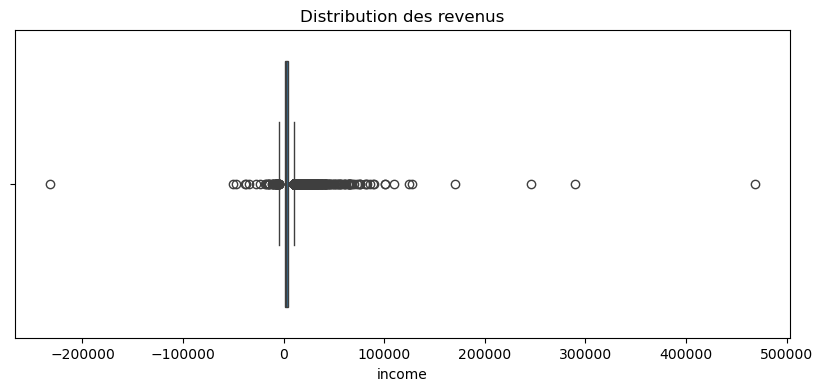

In [13]:
plt.figure(figsize=(10,4))
sns.boxplot(x=df_clean['income'])
plt.title('Distribution des revenus')
plt.show()

## 4. Réduction de dimensionnalité

Pour la visualisation et le clustering, on utilise PCA (2 ou 3 composantes)

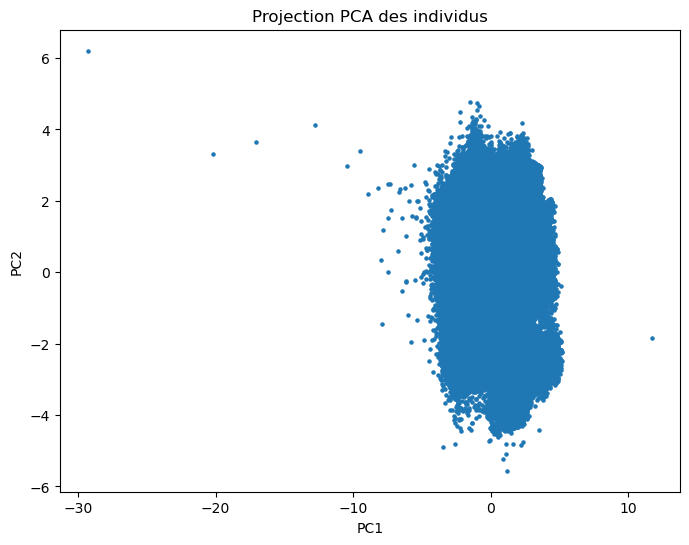

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=5)
plt.title('Projection PCA des individus')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 5. Clustering
### 5.1 K-means - choix du nombre de clusters

In [17]:
X_scaled.shape

(92857, 294)

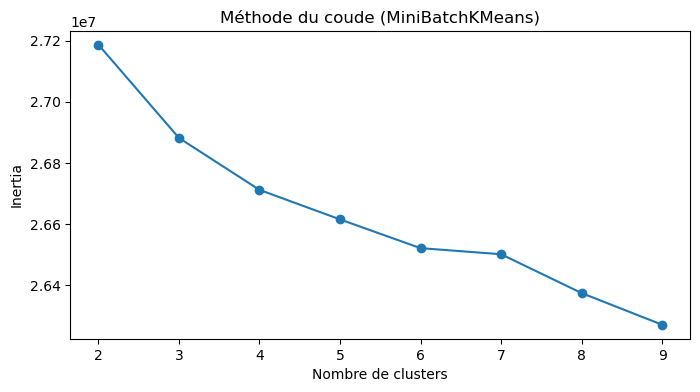

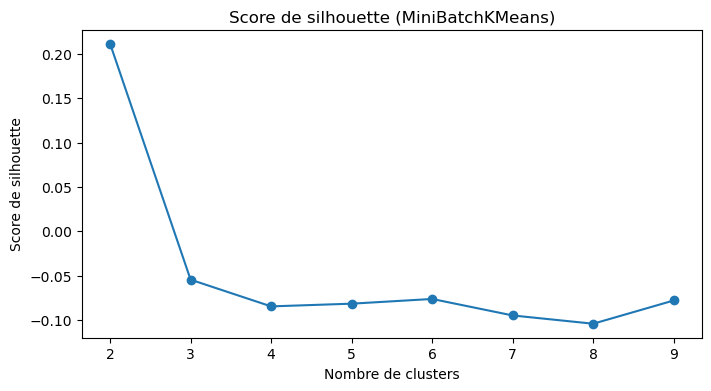

In [18]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    mbk = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42, n_init='auto')
    mbk.fit(X_scaled)
    inertia.append(mbk.inertia_)
    # Calcul du score silhouette sur un échantillon réduit pour accélérer
    sil_scores.append(silhouette_score(X_scaled, mbk.labels_, sample_size=10000, random_state=42))

plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, '-o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertia')
plt.title('Méthode du coude (MiniBatchKMeans)')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(K_range, sil_scores, '-o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette (MiniBatchKMeans)')
plt.show()


#### Application K-means avec le meilleur k

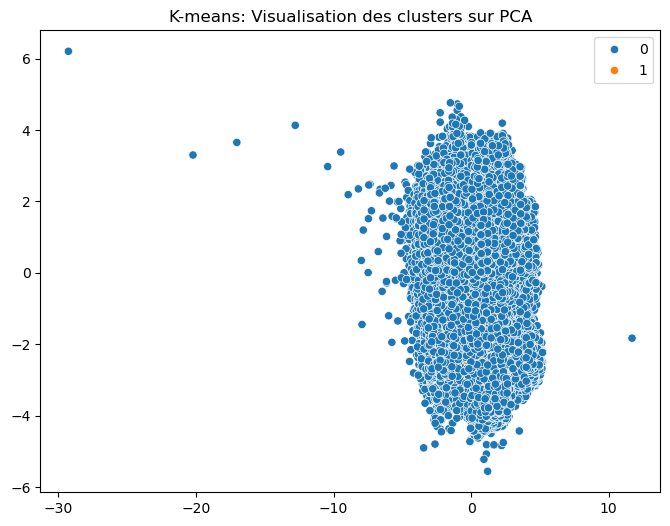

Score silhouette (K-means): 0.231


In [19]:
best_k = K_range[np.argmax(sil_scores)]
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
clusters_kmeans = kmeans_final.fit_predict(X_scaled)
df_clean['cluster_kmeans'] = clusters_kmeans

# Visualisation PCA + clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_kmeans, palette='tab10',legend='full')
plt.title('K-means: Visualisation des clusters sur PCA')
plt.show()

print(f"Score silhouette (K-means): {silhouette_score(X_scaled, clusters_kmeans):.3f}")

### 5.2 Agglomerative Clustering

Score silhouette (Agglomerative): 0.910


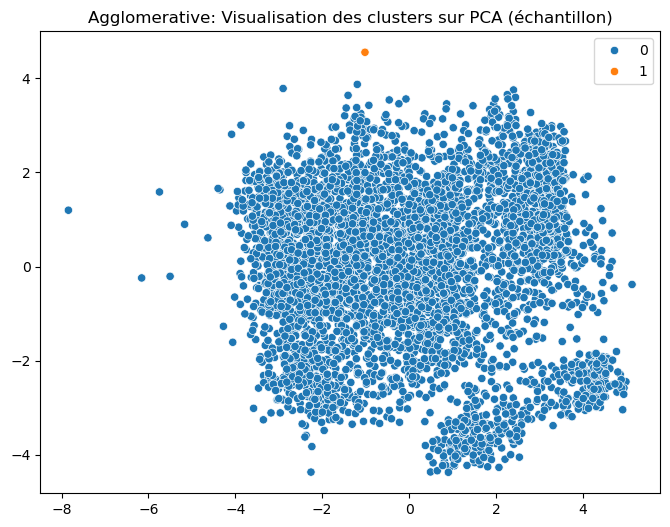

In [21]:
# Je prends un échantillon aléatoire de 5000 lignes (car PC pas assez puissant)
sample_size = min(5000, len(X_scaled))
X_scaled_sample = X_scaled.sample(n=sample_size, random_state=42)
df_clean_sample = df_clean.loc[X_scaled_sample.index]
X_pca_sample = X_pca[X_scaled_sample.index, :]

agglo = AgglomerativeClustering(n_clusters=best_k)
clusters_agglo = agglo.fit_predict(X_scaled_sample)
df_clean_sample['cluster_agglo'] = clusters_agglo
print(f"Score silhouette (Agglomerative): {silhouette_score(X_scaled_sample, clusters_agglo):.3f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca_sample[:,0], y=X_pca_sample[:,1], hue=clusters_agglo, palette='tab10',legend='full')
plt.title('Agglomerative: Visualisation des clusters sur PCA (échantillon)')
plt.show()

### 5.3 DBSCAN
Test de différents paramètres eps/min_samples (peut nécessiter plusieurs essais)

In [23]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)
df_clean['cluster_dbscan'] = clusters_dbscan
n_noise = sum(clusters_dbscan == -1)
n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
print(f"Nombre de clusters DBSCAN: {n_clusters_dbscan}, bruit: {n_noise}")
# On filtre X_scaled pour ne garder que les points non bruités
mask = clusters_dbscan != -1
X_scaled_no_noise = X_scaled[mask]
labels_no_noise = clusters_dbscan[mask]

if n_clusters_dbscan > 1 and len(labels_no_noise) > 0:
    print(f"Score silhouette (DBSCAN): {silhouette_score(X_scaled_no_noise, labels_no_noise):.3f}")

Nombre de clusters DBSCAN: 2571, bruit: 41804
Score silhouette (DBSCAN): 0.409


## 6. Comparaison & Interprétation
- Quels paramètres/méthodes fonctionnent le mieux ?
- Discussion sur la pertinence des clusters (profil des clusters, variables discriminantes)
- Limites et difficultés (outliers, bruit, variable dominante, etc.)

In [24]:
# Profil des clusters (exemple sur K-means)
cluster_profiles = df_clean.groupby('cluster_kmeans')[num_vars].mean()
print(cluster_profiles)
df_clean['cluster_kmeans'].value_counts()

                     income  family_member    year_born         year      wave
cluster_kmeans                                                                
0               3444.987685       2.483806  1952.953724  2011.533711  7.533711
1               2064.504712       2.661538  1954.030769  2005.907692  1.907692


cluster_kmeans
0    92597
1      260
Name: count, dtype: int64

### Discussion finale
- Les scores de silhouette permettent de comparer objectivement les méthodes : plus proche de 1, mieux c'est.
- Les clusters révèlent des groupes distincts selon revenu, taille de famille, etc.
- DBSCAN détecte le bruit mais nécessite un tuning précis des paramètres.
- Les problèmes rencontrés : outliers, valeurs manquantes, dominance de certaines variables.
- Les clusters sont à interpréter en lien avec le contexte social/économique coréen (à approfondir dans le rapport PDF).

# 7. Conclusion
Ce notebook pose les bases d'une étude de clustering robuste sur le jeu de données fourni. Pour le rapport PDF, il faudra étoffer l'interprétation, contextualiser les résultats, et discuter des choix méthodologiques.